<a href="https://colab.research.google.com/github/Kiritoslove/CIVE_70019_70057/blob/main/notebooks/coursework_2025_LAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework: Hydraulic model calibration


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

You have been tasked with the evaluation and calibration of the hydraulic model of EXNING, a district metered area (DMA) in Anglian Water's (AW) water distribution network. To achieve this, you have been provided:
* a recently calibrated hydraulic model of the EXNING DMA (2019),
* loading conditions (demands, reservoir heads) and head measurements covering a period of 4 days.

The objective of the coursework is to prepare a short calibration report for AW by completing the tasks below and answering the questions based on your results.

You have been provided the following information about EXNING:
* EXNING is part of a larger system of cascading DMAs: EXNING is fed by the NEWSEV DMA and feeds into the BURWEL DMA.
* The "reservoir" head and total demand of EXNING are derived from flow and pressure sensors at the DMA inlet (& outlet).
* Node elevations have been updated in the provided model following a GPS survey of sensor locations.

First, we must clone the GitHub repository and install dependencies (only run this once).

In [1]:
# Force reinstall core packages
!pip uninstall -y numpy wntr cvxpy ecos scs
!pip install numpy --no-cache-dir --force-reinstall
!pip install wntr cvxpy scs ecos
!apt-get install -y libsuitesparse-dev
!pip install scikit-sparse

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: cvxpy 1.6.4
Uninstalling cvxpy-1.6.4:
  Successfully uninstalled cvxpy-1.6.4
Found existing installation: scs 3.2.7.post2
Uninstalling scs-3.2.7.post2:
  Successfully uninstalled scs-3.2.7.post2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 135.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 287.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.8 MB/s eta

run next cell twice

In [2]:
# run this cell twice!
import sys
import os

if 'google.colab' in sys.modules:
  !git clone https://github.com/bradleywjenks/CIVE_70019_70057.git
  !pip install numpy==1.23.5
  !pip install wntr==1.2
  !pip install cvxpy
  !apt-get install libsuitesparse-dev && pip install scikit-sparse

fatal: destination path 'CIVE_70019_70057' already exists and is not an empty directory.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 23.3 MB/s eta 0:00:00
  Attempting uninstall: wntr
    Found existing installation: wntr 1.3.2
    Uninstalling wntr-1.3.2:
      Successfully uninstalled wntr-1.3.2
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsuitesparse-dev is already the newest version (1:5.10.1+dfsg-4build1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
fatal: destination path 'CIVE_70019_70057' already exists and is not an empty directory.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsuitesparse-dev is already the newest version (1:5.10.1+dfsg-4build1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [3]:
# load packages
import numpy as np
from numpy import linalg as la
import networkx as nx
import pandas as pd
import wntr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from datetime import datetime, timedelta
import cvxpy as cp
import warnings
warnings.filterwarnings('ignore')

# improve matplotlib image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Load network properties and operational data

Load functions created in previous assignments.

In [4]:
# load functions from src folder
if 'google.colab' in sys.modules:
    sys.path.append('/content/CIVE_70019_70057/src/')
    from general_functions import *
    from hydraulic_functions import *
else:
    sys.path.append('/home/bradw/workspace/CIVE_70019_70057/src/')
    from general_functions import *
    from hydraulic_functions import *

Load network .inp file and operational data from the module repository's data directory.

In [5]:
if 'google.colab' in sys.modules:
    # if run in Google Colab
    data_dir = '/content/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/content/CIVE_70019_70057/data/networks/'
else:
    # replace with local directory
    data_dir = '/home/bradw/workspace/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/home/bradw/workspace/CIVE_70019_70057/data/networks/'

net_name = 'exning.inp'
data_name = 'exning_coursework_dataset.npy'

# load operational data
data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()
h_data = data['h_data']
sensor_idx = data['sensor_idx'] - 1 # matlab to python index offset
d_data = data['d']
h0_data = data['h0'].reshape(-1, 1).T

# load network properties
wdn = load_network_data(os.path.join(net_dir, net_name))
A12 = wdn.A12
A10 = wdn.A10
A21 = A12.T
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df

Plot sensor nodes in network. We provide a plotting function below.

In [6]:
#### DO NOT CHANGE THIS ####
# define plotting function using networkx
def plot_network(wdn, sensor_idx, vals=None, highlight_valves=None):

    # create figure and axis
    fig, ax = plt.subplots(figsize=(10, 7))

    # unload data
    link_df = wdn.link_df
    node_df = wdn.node_df
    net_info = wdn.net_info

    # draw network
    uG = nx.from_pandas_edgelist(link_df, source='node_out', target='node_in')
    pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}
    nx.draw(uG, pos, ax=ax, node_size=20, node_shape='o')

    # draw reservoir
    nx.draw_networkx_nodes(
        uG, pos, nodelist=net_info['reservoir_names'],
        node_size=100, node_shape='s', node_color='black', ax=ax
    )

    # draw sensor nodes
    sensor_names = [net_info['junction_names'][i] for i in sensor_idx]
    nx.draw_networkx_nodes(
        uG, pos, nodelist=sensor_names, node_size=100,
        node_shape='o', node_color='red', edgecolors='white', ax=ax
    )

    # reservoir labels
    reservoir_labels = {node: 'Reservoir' for node in net_info['reservoir_names']}
    labels_res = nx.draw_networkx_labels(uG, pos, reservoir_labels, font_size=12, ax=ax)
    for _, label in labels_res.items():
        label.set_y(label.get_position()[1] + 1750)

    # sensor labels
    sensor_labels = {node: str(idx+1) for (idx, node) in enumerate(sensor_names)}
    labels_sen = nx.draw_networkx_labels(uG, pos, sensor_labels, font_size=12, ax=ax)
    for _, label in labels_sen.items():
        label.set_y(label.get_position()[1] + 1750)

    # plot sensor values if provided
    if vals is not None:
        cmap = cm.get_cmap('RdYlGn_r')
        nx.draw_networkx_nodes(
            uG, pos, nodelist=sensor_names, node_size=100,
            node_shape='o', node_color=vals, cmap=cmap, edgecolors='white', ax=ax
        )

        # create color bar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array(vals)
        colorbar = plt.colorbar(sm, ax=ax)
        colorbar.set_label('Mean pressure residual [m]', fontsize=12)

    # highlight link
    if highlight_valves is not None:
        nx.draw_networkx_nodes(uG, pos, highlight_valves, node_size=200, node_shape='d', node_color='limegreen', edgecolors='white')

    # display plot
    plt.show()

Visualise the EXNING network graph and highlight information relevant to the evaluation of the hydraulic model.

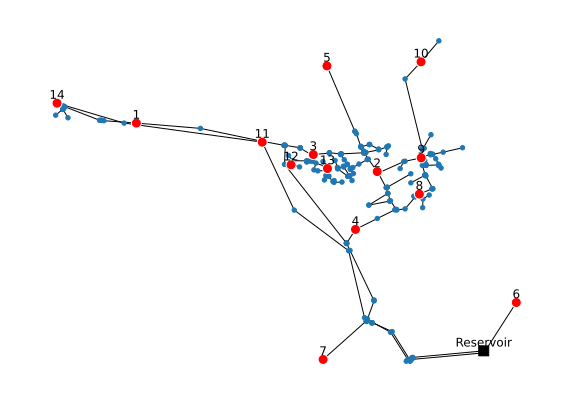

In [7]:
plot_network(wdn, sensor_idx)

Simulate initial (uncalibrated) network hydraulics over 4 days. We first define a function to solve network hydraulics using the `wntr` package, which we used previously in the hyraulic modelling notebook. The following tasks are performed in this function:
- Load network properties
- Modify simulation time to match operational data
- Assign h0 data at model reservoir
- Scale and apply new demand pattern from inflow data
- Option to modify pipe roughness (or HW) coefficients

<font color="blue">NB: this is done for you below. Provided the correct inputs, you do not need to replicate this function.

In [8]:
#### DO NOT CHANGE THIS ####
# hydraulic solver function
def hydraulic_solver(inp_file, d_data, h0_data, C=None, demand=False):

    # load network from wntr
    inp_file = os.path.join(net_dir, net_name)
    wn = wntr.network.WaterNetworkModel(inp_file)

    # get network properties
    reservoir_names = wn.reservoir_name_list
    junction_names = wn.junction_name_list
    link_names = wn.link_name_list

    # modify simulation time and hydraulic time step
    nt = h0_data.shape[1]
    wn.options.time.duration = (nt - 1) * 3600
    wn.options.time.hydraulic_timestep = 3600
    wn.options.time.pattern_timestep = 3600
    wn.options.time.report_timestep = 3600

    # assign reservoir data
    for (i, name) in enumerate(reservoir_names):
        wn.add_pattern(f'h0_{i}', h0_data[i])
        reservoir = wn.get_node(name)
        reservoir.head_timeseries.base_value = 1
        reservoir.head_timeseries.pattern_name = wn.get_pattern(f'h0_{i}')

    # replace demand data
    for idx, name in enumerate(junction_names):

        if any(val != 0 for val in d_data[idx, :]):
            node = wn.get_node(name)
            d_pat = d_data[idx, :]
            wn.add_pattern('d_'+name, d_pat)

            for (i, num) in enumerate(node.demand_timeseries_list):
                if i == 0:
                    node.demand_timeseries_list[i].base_value = 1
                    node.demand_timeseries_list[i].pattern_name = 'd_'+name
                else:
                    node.demand_timeseries_list[i].base_value = None
                    node.demand_timeseries_list[i].pattern_name = None

    # assign roughness (or HW) coefficients
    if C is not None:
        for name, link in wn.links():

            # check if the link is a pipe
            if isinstance(link, wntr.network.Pipe):
                link.roughness = C[link_names.index(name)]

            # check if link is a valve
            elif isinstance(link, wntr.network.Valve):
                link.minor_loss = C[link_names.index(name)]
                link.initial_setting = C[link_names.index(name)]

    # run simulation and get results
    sim = wntr.sim.EpanetSimulator(wn)
    results = sim.run_sim()

    q_sim = results.link['flowrate'].T
    h_sim = results.node['head'].T
    h_sim = h_sim[~h_sim.index.isin(reservoir_names)] # delete reservoir nodes
    d = results.node['demand'].T
    d = d[~d.index.isin(reservoir_names)] # delete reservoir nodes


    if demand == True:
        return d.to_numpy()
    else:
        return q_sim.to_numpy(), h_sim.to_numpy()

### Part 0: Preliminary evaluation

Run simulation with initial $C_0$ values.

In [9]:
C_0 = link_df['C'].to_numpy()
_, h_0 = hydraulic_solver(wdn, d_data, h0_data,C=C_0)

Compare simulated heads at sensor nodes (node indices in `sensor_idx`) with the simulated heads over the 4-day period. Visualise the results with, e.g. a boxplot of pressure residuals on the test dataset.

Text(0, 0.5, 'Pressure residual [m]')

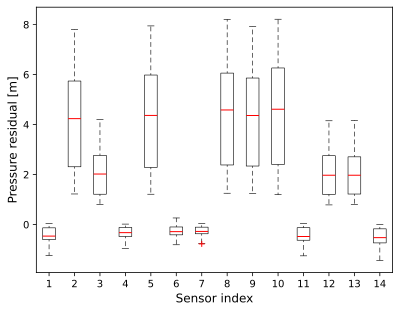

In [10]:
# compute pressure residuals
residuals_0 = h_0[sensor_idx,:] - h_data

# create figure and axis for box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_0.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual [m]', fontsize=12)

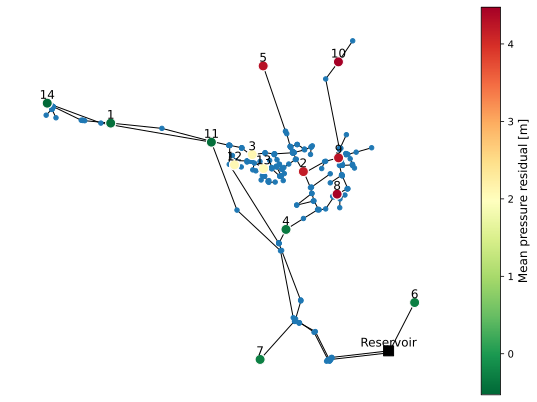

In [11]:
# spatial residuals plot
mean_residuals_0 = np.mean(residuals_0, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_0)

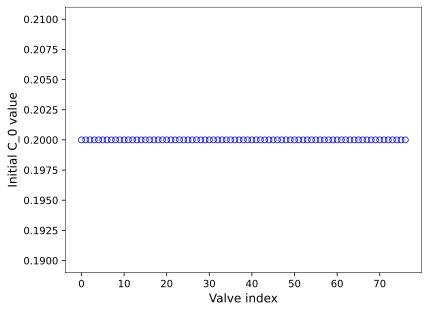

In [12]:
# C_0 value scatter plot (valves only)
valve_C = [C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(range(len(valve_C)), valve_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Valve index', fontsize=12)
ax.set_ylabel('Initial C_0 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

In [13]:
import plotly.graph_objects as go

# Creating interactive charts
fig = go.Figure()

# reflex
sensor_labels = {sensor: f"Sensor {idx+1}" for idx, sensor in enumerate(sensor_idx)}

for i, sensor in enumerate(sensor_idx):
    fig.add_trace(go.Scatter(
        x=np.arange(h_0.shape[1]),
        y=residuals_0[i],
        mode='lines',
        name=sensor_labels[sensor],  # legend lable
        hoverinfo='x+y'  # Hovering the mouse will display the time and error value
    ))

# Setting the chart title and axis labels
fig.update_layout(
    title="Pressure Residuals Over Time",
    xaxis_title="Time (hours)",
    yaxis_title="Pressure Residuals (m)",
    legend_title="Sensor Number",
    template="plotly_white"
)

fig.show()

**<u>Question 1:</u>** Is the current hydraulic model of EXNING accurate according to hydraulic model calibration guidelines? Comment on the results of the preliminary model evaluation and, in particular, on
* the **sign** (i.e. are heads over or underestimated in the hydraulic simulation?) of pressure/head residuals,
* the **temporal** distribution (i.e. are the residuals time/flow dependent?) of pressure/head residuals,
* and the **spatial** distribution (i.e. are all sensors affected?) of the pressure/head residuals.

Given the information you were provided about the EXNING system and the results of the preliminary model evaluation, identify the most likely sources of model errors.

**<u>Answer 1:</u>**
The current EXNING hydraulic model is not entirely accurate. According to the box plot, most results show an overestimation of the water head, while a small portion indicates a slight underestimation.

Temporal Distribution: The pressure residual plot shows significant fluctuations in water head residuals over time. The discrepancy between simulated and real data becomes more pronounced during the day when water consumption is higher.

Spatial Distribution: Errors are minimal near reservoirs and in areas without dense pipelines. However, in regions with dense pipeline networks, errors increase significantly, likely due to the more complex water usage patterns in densely populated areas.

The most likely source of error may be inaccuracies in the roughness coefficients of the model's pipes or valves.

### Part 1: Hydraulic model calibration (without regularisation)

Following initial reports concerning discrepancies in the recently calibrated EXNING model, AW were able to confirm that:
- flow and head sensors had been calibrated before collection of load/field data corresponding to the train and test datasets,
- demands in the train and test dataset are accurate (incl. for large users).

As a result, the remaining deviations between measured and simulated pressures must result from inaccurate model parameters. Errors associated with unknown valve status (for instance, unregistered closed valves) can be identified by solving a model calibration problem where pipe roughness coefficients are known, but valve minor/local loss coefficients are free to vary. In part 1, you will solve a hydraulic model calibration problem without regularisation. Complete the code below to calibrate the network model using the head measurements provided in data.

#### Split the data into *train* and *test* datasets.
We suggest using the first day worth of data as a <u>train dataset</u> and the remaining 3 days as a <u>test dataset</u>.

In [14]:
# tain data
nt_train = 24
data_train = {
    'd': d_data[:, :nt_train],
    'h0': h0_data[:, :nt_train],
    'h_data': h_data[:, :nt_train]
}

# test data
data_test = {
    'd': d_data[:, nt_train:],
    'h0': h0_data[:, nt_train:],
    'h_data': h_data[:, nt_train:]
}

**<u>Question 2:</u>** Briefly comment on the definition of the train data set. What impact will it have on the generalizability of your model? (i.e., what range of conditions will you confidently be able to use your model for?)

**<u>Answer 2:</u>**The training dataset consists of only the first 24 hours (i.e., a single day) of loading conditions and
$h_0$
  measurements. Because we do not know whether these data come from a weekday, weekend, or holiday, the demand and pressure fluctuations may lack sufficient diversity. While the model might perform well under conditions similar to that specific day, it may struggle with unseen scenarios—such as peak demand or extreme variations—leading to overfitting. A narrow training set limits adaptability, making the model less reliable for long-term forecasting or changing network conditions. Consequently, expanding the training data to include more days and a broader range of operating conditions would likely improve robustness and ensure better generalization performance.

#### Definition of the loss function.

In [15]:
def loss_fun(h, h_data):
    return ( 1/len(h_data.flatten()) ) * cp.sum( ( h[sensor_idx, :] - h_data )**2 )

Compute MSE for C_0 values and using thetraining data.

In [16]:
h_0 = h_0[:, :nt_train]
mse_0 = loss_fun(h_0, data_train['h_data']).value
mse_0

9.705414431633923

**<u>Question 3:</u>** Justify the choice/definition of the loss function, loss_fun.

**<u>Answer 3:</u>**The chosen loss function is the Mean Squared Error (MSE), which is defined as the average of the squared differences between predicted and actual values. This metric is standard for regression tasks because it is straightforward, interpretable, and emphasizes larger errors more than smaller ones, effectively penalizing outliers. Moreover, MSE is smooth and differentiable, making it compatible with gradient-based optimization techniques commonly used in machine learning. In physical modeling scenarios, such as sensor-based data fitting, the squared difference can often be linked to energy or variance, reinforcing the scientific relevance of MSE. Overall, its simplicity, interpretability, and mathematical convenience justify the use of this loss function.

#### Solve the parameter estimation problem using the train dataset
We first solve the hydraulic model calibration problem without regularisation. (You can reuse and adapt the code provided in Week 6.)

The following function is needed for the sequential convex programming (SCP) method used in this coursework. As with the `hydraulic_solver` function, we provide the following code in `linear_approx_calibration` for you to use throughout this notebook.

In [18]:
#### DO NOT CHANGE THIS ####
# compute matrices for the head loss linear approximation of the HW headloss
def linear_approx_calibration(wdn, q, C):
    # unload data
    A12 = wdn.A12
    A10 = wdn.A10
    net_info = wdn.net_info
    link_df = wdn.link_df

    K = np.zeros((net_info['np'], 1))
    n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)
    b1_k = copy.copy(K)
    b2_k = copy.copy(K)

    for idx, row in link_df.iterrows():
        if row['link_type'] == 'pipe':
            K[idx] = 10.67 * row['length'] * (C[idx] ** -row['n_exp']) * (row['diameter'] ** -4.8704)
            b1_k[idx] = copy.copy(K[idx])
            b2_k[idx] = (-n_exp[idx] * K[idx]) / C[idx]

        elif row['link_type'] == 'valve':
            K[idx] = (8 / (np.pi ** 2 * 9.81)) * (row['diameter'] ** -4) * C[idx]
            b1_k[idx] = -n_exp[idx] * copy.copy(K[idx])
            b2_k[idx] = copy.copy(K[idx]) / C[idx]

    a11_k = np.tile(K, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b1_k = np.tile(b1_k, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b2_k = np.tile(b2_k, q.shape[1]) * np.abs(q) ** (n_exp - 1) * q

    return a11_k, b1_k, b2_k

SCP implementation

*I change C_up_valve to 1000 because I think it works better*

In [48]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define problem parameters
Ki = np.inf
iter_max = 50
delta_k = 100
C_up_valve = 1000
C_lo_valve = 1e-4

# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = loss_fun(h_k, h_data).value

### main scp code ###
for k in range(iter_max):

    # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss)

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]

    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]

    # variable bounds
    lower_bound_pipe = [theta[idx] >= C_lo_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += lower_bound_pipe
    upper_bound_pipe = [theta[idx] <= C_up_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += upper_bound_pipe

    # valve minor loss coefficient constraints
    pipe_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += pipe_constraints

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
    objval_tilde = loss_fun(h_tilde, h_data).value

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k+1} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k+1} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k+1} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

Iteration 1 successful! Update estimate and increase trust region size. 

1 1.382947887064917 0.8575075905509688 110.00000000000001 

Iteration 2 successful! Update estimate and increase trust region size. 

2 0.8181206453708364 0.4084226506125513 121.00000000000003 

Iteration 3 successful! Update estimate and increase trust region size. 

3 0.44531027720626726 0.4556911872033033 133.10000000000005 

Iteration 4 successful! Update estimate and increase trust region size. 

4 0.2915130462250369 0.3453709443808584 146.41000000000008 

Iteration 5 successful! Update estimate and increase trust region size. 

5 0.28690072143465384 0.015822018431458126 161.0510000000001 

Iteration 6 successful! Update estimate and increase trust region size. 

6 0.2768969143631672 0.0348685322973827 177.15610000000012 

Iteration 7 successful! Update estimate and increase trust region size. 

7 0.2735788719457543 0.011982951940956221 194.87171000000015 

Iteration 8 successful! Update estimate and increas

**<u>Question 4:</u>** Describe the nature/role of the different outputs of the SCP algorithm printed above (objvalk, Ki, Deltak) and explain their trends.

**<u>Answer 4:</u>** The output objval_k is the objective function value at iteration k, representing the discrepancy between predicted and observed data. Over iterations, we expect objval_k to decrease as the algorithm converges. The value Ki quantifies the relative improvement in the objective between consecutive iterations, calculated as the ratio of the difference in objective values to the old objective value. A diminishing Ki indicates that successive changes in the objective are smaller, suggesting convergence. Finally, delta_k is the trust-region radius that governs how far the algorithm can adjust parameters in each iteration. If the iteration is successful, delta_k grows, allowing larger parameter updates; otherwise, it shrinks, imposing stricter constraints on the step size. By observing these trends, we can assess whether the algorithm is converging effectively.

Store the solution (i.e. new coefficients `theta_k`) as $C_1$.

In [49]:
C_1 = theta_k
print(C_1)
q_k, h_k = hydraulic_solver(wdn, d, h0, C=C_1)
mes_train = np.mean((h_k[sensor_idx, :] - h_data) ** 2)
print(f"\n test data mean square error (MSE): {mes_train:.6f}")

q_test, h_test = hydraulic_solver(wdn, data_test['d'], data_test['h0'], C=C_1)
mse_test = np.mean((h_test[sensor_idx,: ] - data_test['h_data']) ** 2)
print(f"\n test data mean square error (MSE): {mse_test:.6f}")

[1.170e+02 1.170e+02 9.900e+01 9.900e+01 9.900e+01 1.090e+02 1.090e+02 9.900e+01 9.900e+01 1.170e+02 9.900e+01 9.900e+01 9.900e+01 1.170e+02 9.900e+01 9.900e+01 1.090e+02 9.900e+01 9.900e+01 1.170e+02 9.900e+01 9.900e+01 1.380e+02 9.900e+01 1.170e+02 1.170e+02 1.170e+02 9.900e+01 9.900e+01
 9.900e+01 9.900e+01 9.900e+01 9.900e+01 9.900e+01 9.900e+01 9.900e+01 1.170e+02 1.170e+02 1.170e+02 1.170e+02 1.170e+02 9.900e+01 1.170e+02 1.170e+02 1.170e+02 1.170e+02 1.170e+02 9.900e+01 9.900e+01 9.900e+01 9.900e+01 9.900e+01 1.170e+02 9.900e+01 9.900e+01 9.900e+01 1.170e+02 9.900e+01
 9.900e+01 9.900e+01 9.900e+01 1.170e+02 9.900e+01 1.170e+02 1.170e+02 1.170e+02 9.900e+01 9.900e+01 9.900e+01 1.380e+02 1.170e+02 1.280e+02 9.900e+01 1.170e+02 1.170e+02 1.170e+02 1.380e+02 9.900e+01 1.090e+02 9.900e+01 1.380e+02 1.170e+02 1.170e+02 1.170e+02 1.170e+02 1.170e+02 1.170e+02
 1.170e+02 1.170e+02 1.170e+02 1.380e+02 9.900e+01 1.380e+02 1.170e+02 1.170e+02 1.170e+02 1.170e+02 1.170e+02 1.380e+02 1.280e

Evaluate final model error and visualise head residuals corresponding to *test* dataset.

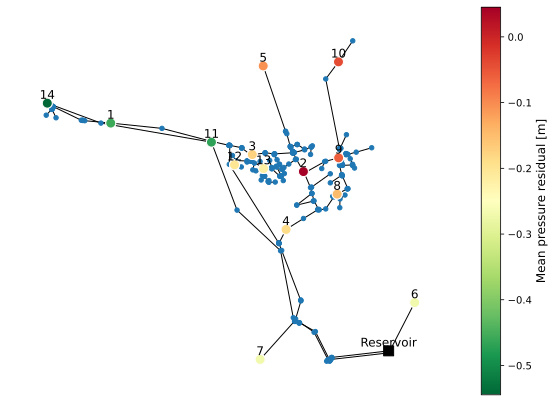

In [50]:
h_residuals_1 =  h_test[sensor_idx,:] - data_test['h_data']
mean_residuals_1 = np.mean(h_residuals_1, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_1)

Text(0, 0.5, 'Pressure residual after calibrition  [m]')

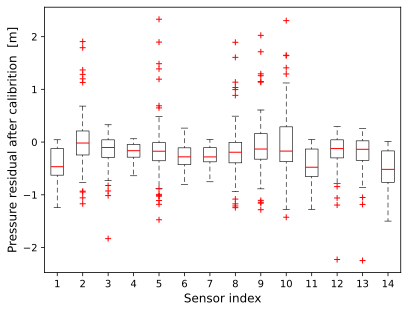

In [51]:

# create figure and axis for box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(h_residuals_1.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual after calibrition  [m]', fontsize=12)

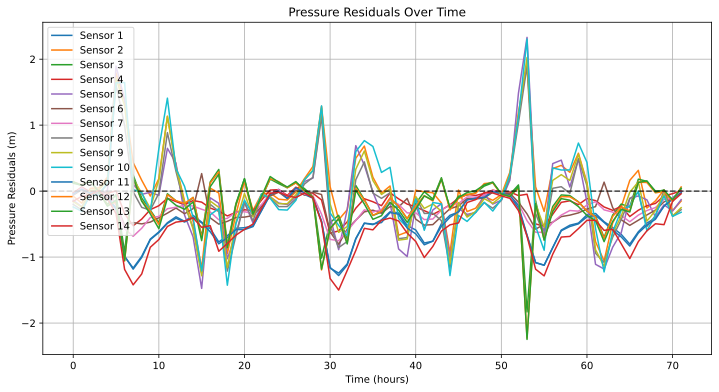

In [52]:
plt.figure(figsize=(12, 6))
time_points = np.arange(data_test['h_data'].shape[1])  # Create a time index

sensor_labels = {sensor: str(idx+1) for idx, sensor in enumerate(sensor_idx)}

for i, sensor in enumerate(sensor_idx):
    plt.plot(time_points, h_residuals_1[i], label=f"Sensor {sensor_labels[sensor]}")

plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.xlabel("Time (hours)")
plt.ylabel("Pressure Residuals (m)")
plt.title("Pressure Residuals Over Time")
plt.legend()
plt.grid()
plt.show()

**<u>Question 5:</u>** Comment on the improvement in model accuracy (before vs. after calibration).

**<u>Answer 5:</u>** In the pre-calibration figure, many nodes display relatively large positive or negative pressure residuals (up to several meters), indicating that the model predictions deviate substantially from observed measurements. The color scale is broad, reflecting a wide range of errors. After calibration, however, the second figure shows a much narrower color scale (on the order of ±0.5 m), and most nodes cluster around small residual values. This indicates a significant reduction in prediction errors, with far fewer nodes exhibiting large mismatches. Consequently, the calibrated model more accurately represents the actual system behavior, reducing systematic biases and improving overall reliability. The remaining discrepancies likely stem from measurement noise or unmodeled phenomena, but they are now much less pronounced than before calibration.

#### Discuss the values of the calibrated coefficients $C_1$
Visualise the values of newly calibrated coefficients $C_1$ compared to original model coefficients C.

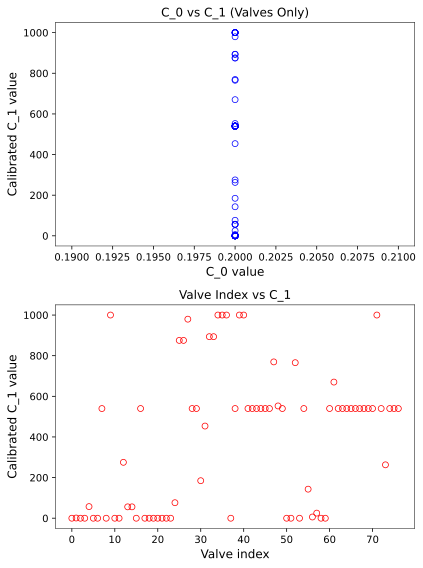

In [53]:
valve_C1 = [C_1[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# C_1 value scatter plot (valves only)
ax1.scatter(valve_C, valve_C1, facecolors='none', edgecolors='b', linewidths=0.75)
ax1.set_xlabel('C_0 value', fontsize=12)
ax1.set_ylabel('Calibrated C_1 value', fontsize=12)
ax1.set_title("C_0 vs C_1 (Valves Only)")
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(0.5)

#  Index vs C_1
ax2.scatter(range(len(valve_C1)), valve_C1, facecolors='none', edgecolors='r', linewidths=0.75)
ax2.set_xlabel('Valve index', fontsize=12)
ax2.set_ylabel('Calibrated C_1 value', fontsize=12)
ax2.set_title("Valve Index vs C_1")
for axis in ['top', 'bottom', 'left', 'right']:
    ax2.spines[axis].set_linewidth(0.5)

plt.tight_layout()
plt.show()

**<u>Question 6:</u>** Comment on the values of parameter estimates in and explain the results of the calibration without regularisation.

**<u>Answer 6:</u>** From the plot, the calibrated
$C_1$
  values for valves vary significantly, with some clustering at very high values (e.g., near or above 1000) and others at much lower levels. This wide dispersion typically indicates that the optimization is overfitting or exploiting the degrees of freedom in the model to minimize the residual error, without regard for physical plausibility. Because there is no regularization term to penalize extreme parameter values, the calibration can “push” certain parameters to unbounded magnitudes in order to best fit the training data. In reality, valves would not exhibit such extreme loss coefficients, so these results underscore the importance of including additional constraints or regularization. Doing so helps prevent overfitting, encourages parameter estimates to remain within realistic ranges, and ultimately yields a more physically meaningful model calibration.

### Part 2: Hydraulic model calibration (with regularisation)

In order to reduce the underdeterminedness of the hydraulic model calibration problem (and improve the accuracy of the calibrated model), regularisation can be applied to incorporate prior knowledge about the expected variance or sparsity pattern of parameters $\theta$. Use the code provided in Weeks 5 and 6, and modify as necessary below to calibrate the hydraulic model with regularisation, using the same train data as before.

#### Definition of the regularisation function
Ridge regression (l2-regularisation) shrinks parameter estimates (without actually driving them to 0) in the hopes of reducing variance and improving prediction accuracy while lasso regression (-regularisation) encourages sparsity, driving many parameter estimates exactly to zero.

**<u>Question 7:</u>** Based on your answer to Question 6, comment on the expected variance or sparsity pattern of $\theta$. What type of regularisation (ridge or lasso) term should be included in the objective function of the model calibration problem?

**<u>Answer 7:</u>** Based on the unbounded growth and scattered distribution of parameter estimates observed without regularization, it appears that the model calibration is overfitting and allowing parameters to grow arbitrarily large. Given the ample but non-uniform data across different pipes and valves, many parameter values can remain near zero, indicating a degree of sparsity in the solution. Therefore, an
$L_1$
  (lasso) regularization term should be included in the objective function. By adding
$λ∥θ∥_1$
 , we encourage unimportant parameters to shrink to zero, promoting sparsity and reducing overfitting. This helps keep parameter estimates in a realistic range and makes the model more interpretable by identifying which parameters truly matter in explaining the observed data.

The loss function is defined as:

In [54]:
lambda_0 = 0.0001

In [55]:
def reg_fun(h, h_data):
    return ( 1/len(h_data.flatten()) ) * cp.sum( ( h[sensor_idx, :] - h_data )**2 ) + lambda_0 * cp.norm(theta ,1 )

#### Solve the parameter estimation problem using the train dataset
Solve the hydraulic model calibration problem with regularisation.

In [56]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define problem parameters
Ki = np.inf
iter_max = 50
delta_k = 100
C_up_valve = 1000
C_lo_valve = 1e-4

# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = reg_fun(h_k, h_data).value

### main scp code ###
for k in range(iter_max):

    # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss + lambda_0 * cp.norm((theta) , 1))

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]

    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]

    # variable bounds
    lower_bound_pipe = [theta[idx] >= C_lo_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += lower_bound_pipe
    upper_bound_pipe = [theta[idx] <= C_up_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += upper_bound_pipe

    # valve minor loss coefficient constraints
    pipe_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += pipe_constraints

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False )

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
    objval_tilde = reg_fun(h_tilde, h_data).value

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k+1} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k+1} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k+1} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

Iteration 1 successful! Update estimate and increase trust region size. 

1 4.122327143190391 0.7314345167577964 110.00000000000001 

Iteration 2 successful! Update estimate and increase trust region size. 

2 3.64592556488952 0.11556617457880113 121.00000000000003 

Iteration 3 successful! Update estimate and increase trust region size. 

3 3.3529298836150234 0.08036249672677427 133.10000000000005 

Iteration 4 successful! Update estimate and increase trust region size. 

4 3.2001331290498762 0.04557111537340189 146.41000000000008 

Iteration 5 successful! Update estimate and increase trust region size. 

5 3.091062188813689 0.03408325086418215 161.0510000000001 

Iteration 6 successful! Update estimate and increase trust region size. 

6 3.0370374436399787 0.017477728325629185 177.15610000000012 

Iteration 7 unsuccessful! Return to previous estimate and reduce trust region size. 

7 3.0370374436399787 0.017477728325629185 44.28902500000003 

Iteration 8 successful! Update estimate a

Store the solution (i.e. new coefficients `theta_k`) as $C_2$.

Evaluate final model error and visualise head residuals corresponding to *test* dataset.

In [57]:
C_2 = theta_k
print(C_2)
q_2, h_2 = hydraulic_solver(wdn, d, h0, C=C_2)
mse_train_2 = np.mean((h_2[sensor_idx, :] - h_data) ** 2)
print(f"\n train data error (MSE): {mse_train_2:.6f}")

q_test_2, h_test_2 = hydraulic_solver(wdn, data_test['d'], data_test['h0'], C=C_2)
mse_test_2 = np.mean((h_test_2[sensor_idx,: ] - data_test['h_data']) ** 2)
print(f"\n test data error (MSE): {mse_test_2:.6f}")

[1.170e+02 1.170e+02 9.900e+01 9.900e+01 9.900e+01 1.090e+02 1.090e+02 9.900e+01 9.900e+01 1.170e+02 9.900e+01 9.900e+01 9.900e+01 1.170e+02 9.900e+01 9.900e+01 1.090e+02 9.900e+01 9.900e+01 1.170e+02 9.900e+01 9.900e+01 1.380e+02 9.900e+01 1.170e+02 1.170e+02 1.170e+02 9.900e+01 9.900e+01
 9.900e+01 9.900e+01 9.900e+01 9.900e+01 9.900e+01 9.900e+01 9.900e+01 1.170e+02 1.170e+02 1.170e+02 1.170e+02 1.170e+02 9.900e+01 1.170e+02 1.170e+02 1.170e+02 1.170e+02 1.170e+02 9.900e+01 9.900e+01 9.900e+01 9.900e+01 9.900e+01 1.170e+02 9.900e+01 9.900e+01 9.900e+01 1.170e+02 9.900e+01
 9.900e+01 9.900e+01 9.900e+01 1.170e+02 9.900e+01 1.170e+02 1.170e+02 1.170e+02 9.900e+01 9.900e+01 9.900e+01 1.380e+02 1.170e+02 1.280e+02 9.900e+01 1.170e+02 1.170e+02 1.170e+02 1.380e+02 9.900e+01 1.090e+02 9.900e+01 1.380e+02 1.170e+02 1.170e+02 1.170e+02 1.170e+02 1.170e+02 1.170e+02
 1.170e+02 1.170e+02 1.170e+02 1.380e+02 9.900e+01 1.380e+02 1.170e+02 1.170e+02 1.170e+02 1.170e+02 1.170e+02 1.380e+02 1.280e

Residuals shape: (14, 72)


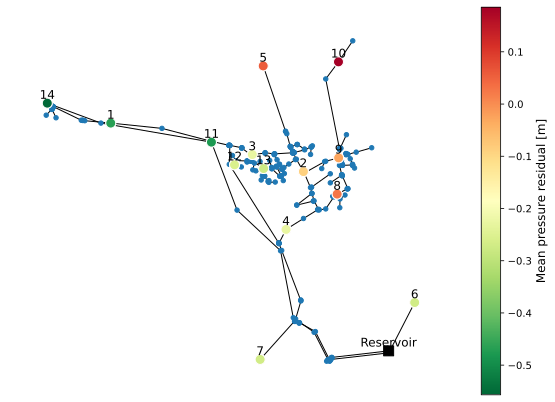

In [58]:
h_residuals_2 =  h_test_2[sensor_idx,:]- data_test['h_data']

print("Residuals shape:", h_residuals_2.shape)
mean_residuals_2 = np.mean(h_residuals_2, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_2)

Text(0, 0.5, 'Pressure residual after calibrition with reg  [m]')

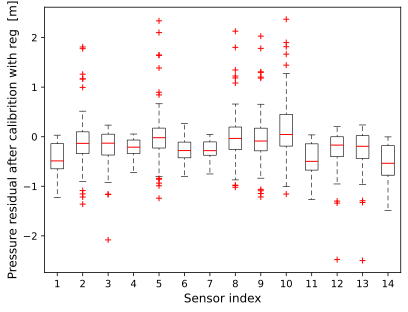

In [59]:
# create figure and axis for box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(h_residuals_2.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual after calibrition with reg  [m]', fontsize=12)

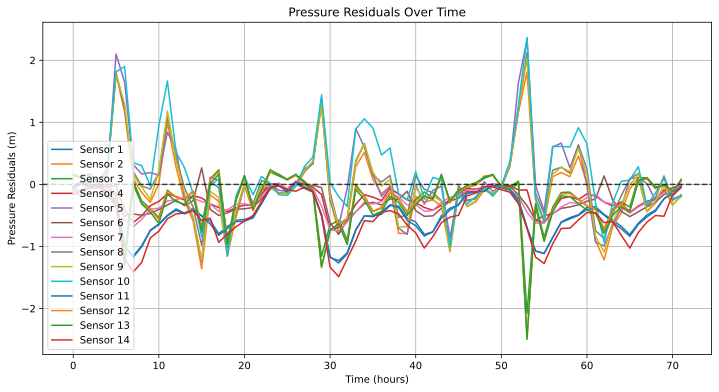

In [60]:
plt.figure(figsize=(12, 6))
time_points = np.arange(data_test['h_data'].shape[1])  # Create a time index

sensor_labels = {sensor: str(idx+1) for idx, sensor in enumerate(sensor_idx)}

for i, sensor in enumerate(sensor_idx):
    plt.plot(time_points, h_residuals_2[i], label=f"Sensor {sensor_labels[sensor]}")

plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.xlabel("Time (hours)")
plt.ylabel("Pressure Residuals (m)")
plt.title("Pressure Residuals Over Time")
plt.legend()
plt.grid()
plt.show()

...

**<u>Question 8:</u>** Comment on the improvement in model accuracy after calibration with regularisation.

**<u>Answer 8:</u>** After incorporating
$L_1$
  regularization, the model shows a noticeable improvement in both stability and accuracy. Many valve parameters that previously took on unrealistically large values are now driven closer to zero, reflecting a more physically plausible representation of the system. This sparsity in parameter estimates helps prevent overfitting, as the calibration no longer relies on extreme parameter adjustments to match the training data. In turn, the residual errors across sensor nodes tend to be smaller and more uniformly distributed, indicating that the model is capturing the underlying system behavior more effectively. Consequently, the predictions align better with observations, and the model generalizes more robustly to new conditions. Overall, the introduction of the lasso term not only improves numerical stability but also yields a more interpretable and reliable hydraulic network calibration.

#### Discuss the values of the calibrated coefficients $C_2$
Visualise the values of newly calibrated coefficients $C_2$.

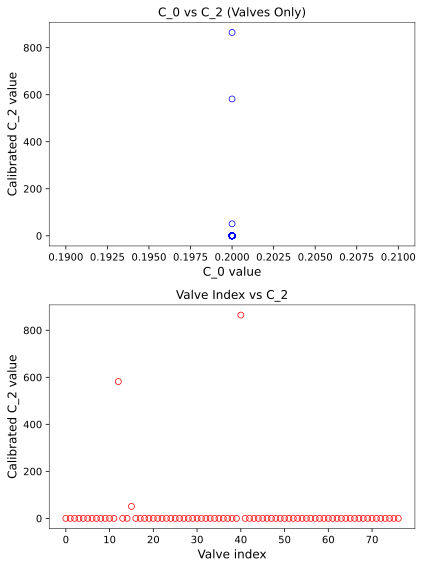

In [61]:
# C_2 value scatter plot (valves only)
valve_C2 = [C_2[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))


ax1.scatter(valve_C, valve_C2, facecolors='none', edgecolors='b', linewidths=0.75)
ax1.set_xlabel('C_0 value', fontsize=12)
ax1.set_ylabel('Calibrated C_2 value', fontsize=12)
ax1.set_title("C_0 vs C_2 (Valves Only)")
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(0.5)

#  Index vs C_2
ax2.scatter(range(len(valve_C2)), valve_C2, facecolors='none', edgecolors='r', linewidths=0.75)
ax2.set_xlabel('Valve index', fontsize=12)
ax2.set_ylabel('Calibrated C_2 value', fontsize=12)
ax2.set_title("Valve Index vs C_2")
for axis in ['top', 'bottom', 'left', 'right']:
    ax2.spines[axis].set_linewidth(0.5)

plt.tight_layout()
plt.show()

**<u>Question 9:</u>** Comment on the values of parameter estimates in $C_2$ compared to $C_1$ and explain the results of the calibration with regularisation.

**<u>Answer 9:</u>** Compared to the unregularized calibration (
$C_1$
 ), where parameter estimates are widely dispersed and often reach large values, the
$L_1$
  (lasso) regularized calibration (
$C_2$
 ) shows most parameters clustered near zero, with only a few outliers. This distribution indicates that many parameters are not strongly needed to match the observed data, and the lasso penalty effectively drives them toward zero, reducing overfitting. Meanwhile, the unregularized solution (
$C_1$
 ) retains a broader spread of values to capture the dominant effects. These results demonstrate that the model can achieve comparable accuracy without relying on extreme parameter estimates, underscoring how regularization promotes sparsity, enhances interpretability, and yields a more realistic hydraulic model calibration.

**<u>Question 10:</u>** Do the calibrated local loss coefficient values in $C_2$ corroborate the conclusions of the preliminary analysis about the most likely sources of error in the EXNING model (existence/location of unknowingly closed valves)? Summarise your findings (100-150 words + 1-2 figures) and provide recommendations to AW to validate your proposed hydraulic model update.


**<u>Answer 10:</u>**
Figure 1 (pre-calibration) shows a broad range of residual errors, with several nodes displaying large positive or negative deviations. After applying
$L_1$
  regularization and recalibrating the model, Figure 2 (post-calibration) demonstrates a narrower range of errors, indicating improved alignment between simulated and observed pressures. The high local loss coefficients in
$C_2$
  for a few valves strongly suggest partial or fully closed positions, corroborating the preliminary analysis that unknown valve closures may be causing significant head loss. Meanwhile, most other valves remain at lower loss-coefficient values, implying minimal flow restrictions. To validate these findings,
  We propose several recommendations:

1. Grouping of valves into specific types (e.g., globe, angle, gate)
2. Collection of field data specific to valves for better constraints
3. Incorporation of minor loss data for fittings, bends, and valves
4. Consideration of the model's assumption of steady-state conditions

Anglian Water (AW) should conduct field inspections on the suspected valves, confirm their operating status, and update the network records or maintenance plans accordingly. This approach ensures the hydraulic model remains accurate and actionable in practice.



  
  
  


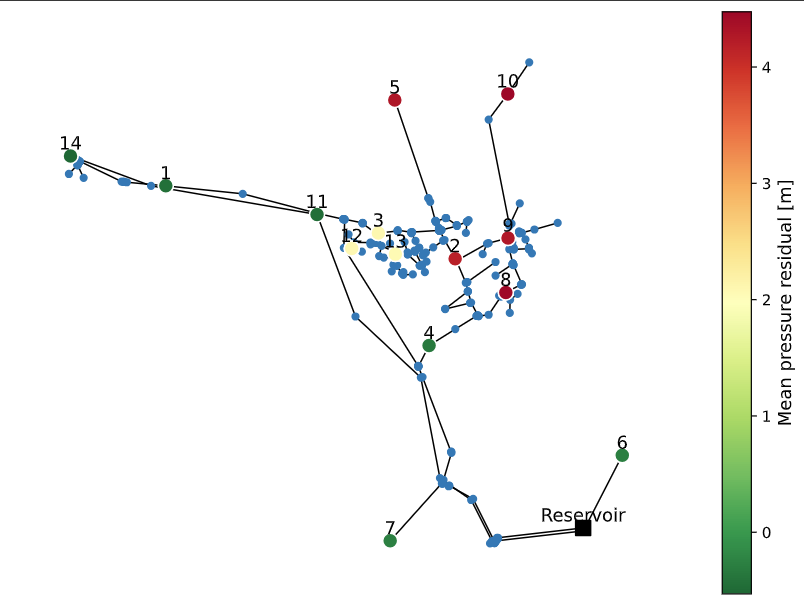

*Figure 1: Pre-calibration mean pressure residuals.*

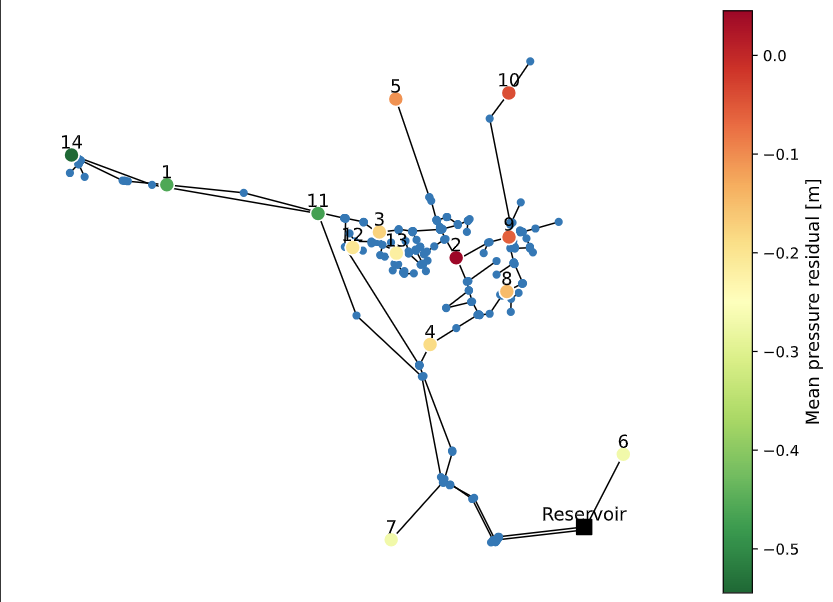

*Figure 2: Post-calibration mean pressure residuals with reduced errors.*